# LAB1 - CNS (Liquid state machine)
Implement a Liquid State Machine model using Izhikevich neurons for the prediction of Sunspot task.

Importation of needed libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Dataset

Loading of dataset from the relative csv file.

In [2]:
with open('solar_data.csv') as file:
    dataset = file.readline().split(',')

dataset = np.array([float(d) for d in dataset])

dataset.shape

(2899,)

Slitting the dataset in input (X) and target (Y) data from the same autoregressive dataset.

In [3]:
X = dataset[:-1]
Y = dataset[1:]

X.shape, Y.shape

((2898,), (2898,))

Splitting in train, validation and test set.

In [4]:
test_size = 500
X_TR, X_TS = X[:-test_size], X[-test_size:]
Y_TR, Y_TS = Y[:-test_size], Y[-test_size:]

validation_size = 300
X_TR, X_VL = X_TR[:-validation_size], X_TR[-validation_size:]
Y_TR, Y_VL = Y_TR[:-validation_size], Y_TR[-validation_size:]

[x.shape for x in [X_TR, X_VL, X_TS]]

[(2098,), (300,), (500,)]

## Model
Class of Liquid State Machine model. In the constructor there are parameters initialization, in `_compute_states` method the process to compute each state through the liquid, `predict` is able to take in input an input data and provide his prediction and `train` is the method able to fit the readout layer.

In [5]:
class LSM:
    """
    Class able to provide a Liquid State Machine model.
    """

    def __init__(
            self,
            n_size: int = 1000,
            e_perc: float = 0.8,
            we_in: float = 5,
            wi_in: float = 2,
            we_l: float = 0.5,
            wi_l: float = 1
    ) -> None:
        """
        Constructor of LSM model.

        n_size: Number of Izhikevich neurons..
        e_perc: Percentage of excitatory neurons..
        we_in: Scaler hyperparam of input weights of excitatory neurons.
        wi_in: Scaler hyperparam of input weights of inhibitory neurons.
        we_l: Scaler hyperparam of liquid weights of excitatory neurons.
        wi_l:Scaler hyperparam of liquid weights of inhibitory neurons.
        """
        ne_size = int(n_size * e_perc)
        ni_size = n_size - ne_size
        re, ri = np.random.rand(ne_size), np.random.rand(ni_size)
        self.a = np.concatenate((0.02 * np.ones(ne_size), 0.02 + 0.08 * ri))
        self.b = np.concatenate((0.2 * np.ones(ne_size), 0.25 - 0.05 * ri))
        self.c = np.concatenate((-65 + 15 * re ** 2, -65 * np.ones(ni_size)))
        self.d = np.concatenate((8 - 6 * re ** 2, 2 * np.ones(ni_size)))
        self.v = np.concatenate((-65 * np.ones(ne_size), -65 * np.ones(ni_size)))
        self.u = self.b * self.v
        self.U = np.concatenate((we_in * np.ones(ne_size), wi_in * np.ones(ni_size)))
        self.S = np.concatenate(
            (we_l * np.random.rand(ne_size + ni_size, ne_size), -wi_l * np.random.rand(ne_size + ni_size, ni_size)),
            axis=1)
        self.readout = np.random.rand(ne_size + ni_size)

    def _compute_states(self, source: np.array) -> np.array:
        """
        Method able to compute states using liquid.

        source: Input values to process.

        returns:
            np.array: Encoded states.
        """
        states = []
        u, v = self.u, self.v
        for t in range(len(source)):
            I = source[t] * self.U
            fired = v >= 30
            v[fired] = self.c[fired]
            u[fired] = u[fired] + self.d[fired]
            I = I + np.sum(self.S[:, fired], axis=1)
            for _ in range(2):
                v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)
            u = u + self.a * (self.b * v - u)
            states.append(np.array(v >= 30, dtype=int))
        return np.array(states)

    def predict(self, source: np.array) -> np.array:
        """
        Method to predict next values given an input.

        source: Input values used to predict the next ones related to the next time step.

        returns:
            np.array: Predictions.
        """
        states = self._compute_states(source)
        return states @ self.readout

    def train(self, source: np.array, targets: np.array, reg: float = 0.1) -> None:
        """
        Method able to train the LSM model.

        source: Input data.
        targets: Target data related to source.
        reg: Regularization hyperparam for Thikonov regularization. If it is None it is computed the simple pseudo-inverse to train the readout.
        """
        states = self._compute_states(source)
        if reg is not None:
            self.readout = np.linalg.pinv(states.T @ states + np.eye(states.shape[1]) * reg) @ states.T @ targets
        else:
            self.readout = np.linalg.pinv(states) @ targets

## Metric
The metric used in this regression problem is the Mean Absolute Error (MAE).

In [6]:
def mean_absolute_error(labels, predictions) -> float:
    """
    Function able to compute the Mean Absolute Error metric.

    labels: Labels given from the dataset.
    predictions: Provided by the model.

    returns:
        float: MAE value.
    """
    return abs(labels - predictions).mean()

## Simulation

Definition of hyperparameters. From these lists inside the dictionary is computed the carthesian product to have a list of dictionaries eache of them containing the configuration readable from the models.

In [7]:
hyperparams_dol = dict(
    n_size=[100, 500, 1000],
    e_perc=[0.8, 0.5],
    we_in=[1, 5],
    wi_in=[1, 5],
    we_l=[0.2, 0.5],
    wi_l=[0.2, 0.5],
)

hyperparams_lod = [dict(zip(hyperparams_dol.keys(), t)) for t in itertools.product(*hyperparams_dol.values())]

len(hyperparams_lod)

96

The combination of hyperparameters values are iterated in a gridsearch to select the best hyperparameters training each new model on training set and evaluating it on validation set using the Mean Absolute Error metric.

In [8]:
best_hyperparams, min_error = None, None
for i, hyperparams in enumerate(hyperparams_lod):
    print(i + 1, '- hyperparams:', hyperparams)
    model = LSM(**hyperparams)
    model.train(X_TR, Y_TR)
    pred_vl = model.predict(X_VL)
    error = mean_absolute_error(Y_VL, pred_vl)
    print('MAE:', error)
    if min_error is None or error < min_error:
        min_error = error
        best_hyperparams = hyperparams

print()
print('Best hyperparams: ', best_hyperparams)
print('MAE:', min_error)

1 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 1, 'we_l': 0.2, 'wi_l': 0.2}
MAE: 29.9285735305377
2 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 1, 'we_l': 0.2, 'wi_l': 0.5}
MAE: 32.332212020531536
3 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 1, 'we_l': 0.5, 'wi_l': 0.2}
MAE: 31.100416908263416
4 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 1, 'we_l': 0.5, 'wi_l': 0.5}
MAE: 31.36527722022526
5 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 5, 'we_l': 0.2, 'wi_l': 0.2}
MAE: 20.789913551849082
6 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 5, 'we_l': 0.2, 'wi_l': 0.5}
MAE: 21.582714618945886
7 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 5, 'we_l': 0.5, 'wi_l': 0.2}
MAE: 21.84301714282509
8 - hyperparams: {'n_size': 100, 'e_perc': 0.8, 'we_in': 1, 'wi_in': 5, 'we_l': 0.5, 'wi_l': 0.5}
MAE: 21.411925605247266
9 - hyperparams: {'n_size': 

Construction of LSM model with the best selected hyperparameters.

In [9]:
model = LSM(**best_hyperparams)

X_TR, X_TS = X[:-test_size], X[-test_size:]
Y_TR, Y_TS = Y[:-test_size], Y[-test_size:]
model.train(X_TR, Y_TR)

tr_pred = model.predict(X_TR)
print('Training MAE:', mean_absolute_error(tr_pred, Y_TR))

Training MAE: 18.73609030603491


Model evaluation on test set.

In [10]:
ts_pred = model.predict(X_TS)
print('Test MAE:', mean_absolute_error(ts_pred, Y_TS))

Test MAE: 29.930155463618448


Definition of function able to plot labels and predictions to compare them.

In [11]:
def plot_ts(title, Y, predictions):
    plt.figure(figsize=(20, 10))
    plt.title(title)
    x = list(range(len(Y)))
    plt.plot(x, Y, label='labels')
    plt.plot(x, predictions, label='predictions')
    plt.xlabel('time')
    plt.ylabel('sunspot')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'lsm_solarspot_plots/{title}.png')
    plt.show()

Plot of comparisons between training labels and predictions.

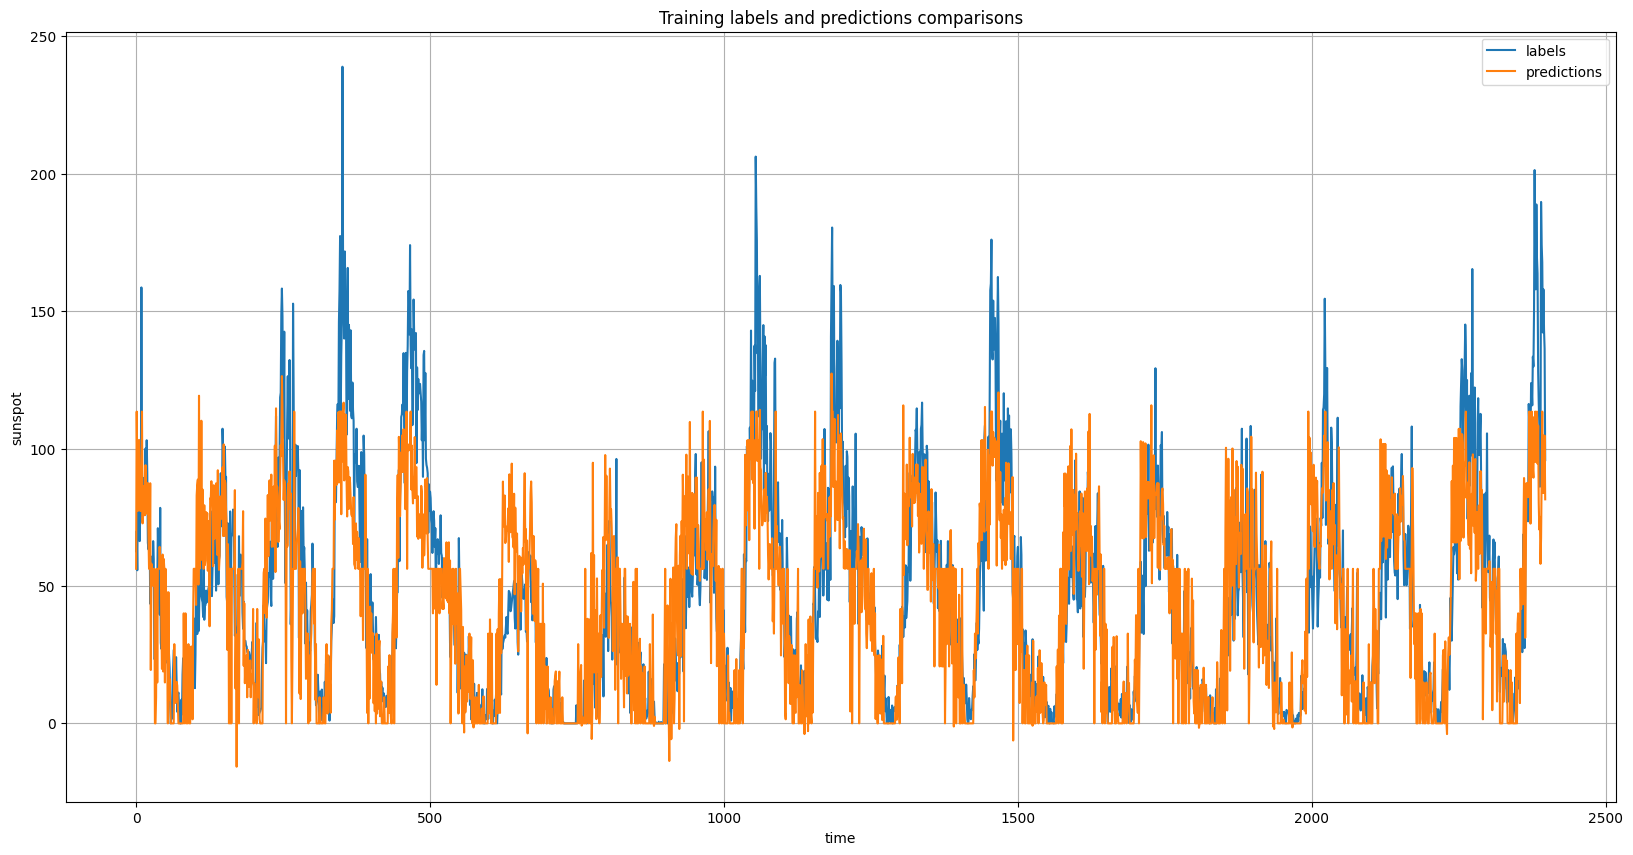

In [12]:
plot_ts('Training labels and predictions comparisons', Y_TR, tr_pred)

Plot of comparisons between test labels and predictions.

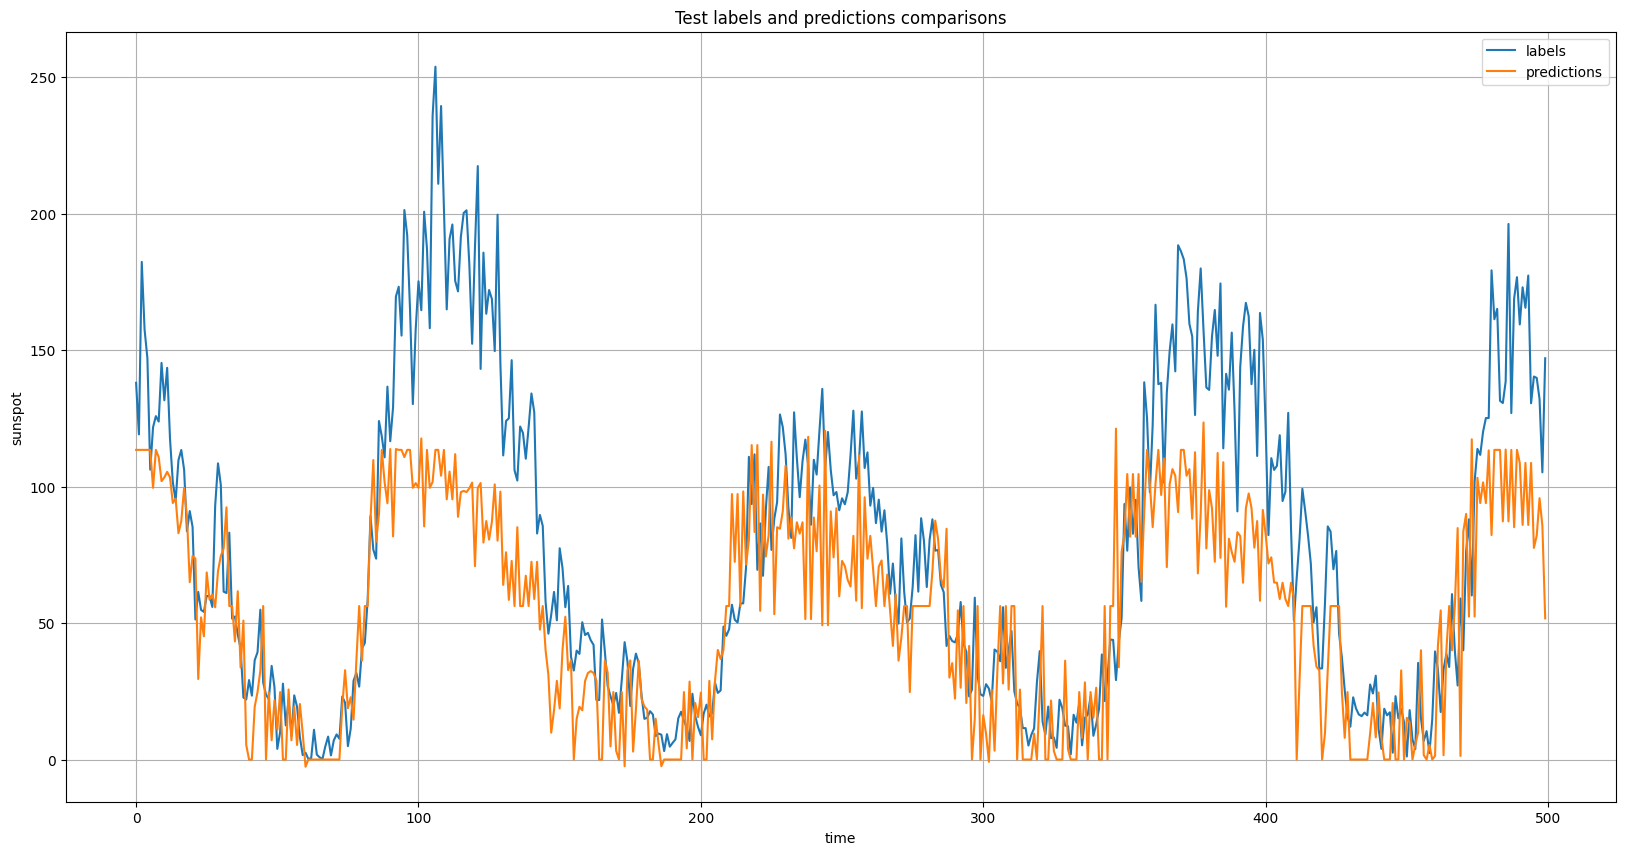

In [13]:
plot_ts('Test labels and predictions comparisons', Y_TS, ts_pred)